In [1]:
import numpy as np
import sympy as sp
from General import functies as functies
from General import classes as classes
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline

In [ ]:
'''
#de exacte oplossing van die fucking derdegraadsveelterm die [H+] beschrijft
H, Ka, Na, c0, a = sp.symbols('H Ka Na c0 a', real = True) #a = concentratie H en OH door autoprotolyse van water
Kw = 10**(-7) #de waterconstante
""" #poging die fout bleek
vergelijking = sp.Eq(H**3 + Ka*H**2 + (Na-Kw*c0)*H + Ka*(Na - Kw), 0)
display(vergelijking)
oplossing = sp.solve(vergelijking, H)
for opl in oplossing:
    testval = opl.subs(Ka, 10**(-4.74)).subs(Na, 0).subs(c0, 1).evalf()
    display(testval)
    print('pH:')
    display(-np.log10(float(abs(testval))))
    print('_________')
    #skip dat imaginair deel, uit de 
print('____________take 2_______________')
#poging 2:"""
vergelijking = sp.Eq(Ka*(c0 + a)*(a+Na)**2 - Kw**2 + Kw*a*(a+Na), 0)
oplossing = sp.solve(vergelijking, a)
#testreeks 1 van de oplossingen:
"""
for opl in oplossing:
    H = Kw/(opl+Na)
    testval = H.subs(Ka, 10**(-4.74)).subs(Na, 0).subs(c0,1).evalf()
    display(testval)
    print('pH:')
    display(-np.log10(float(abs(testval))))
    print('______')
#gezien hier pH = 1/2 pKa - 1/2 log cA = 4.74/2, valt de eerste oplossing al af
print('Voor een 50/50 buffermengsel:')
for opl in oplossing:
    H = Kw/(opl+Na)
    testval = H.subs(Ka, 10**(-4.74)).subs(Na, 1/2).subs(c0,1).evalf()
    display(testval)
    print('pH:')
    display(-np.log10(float(abs(testval))))
    print('______')
#gezien hier pH = pKa - log(cA/cB) = 4.74 moet het de tweede oplossing (op index 1) zijn die we zoeken"""

exacteoplossing_a = sp.re(sp.simplify(oplossing[1].subs(Ka, 10**(-4.74))))
exacteoplossing = Kw/(exacteoplossing_a +Na)
display(exacteoplossing)
# Convert the symbolic expression to a numerical function
f_exacteoplossing = sp.lambdify((c0, Na), sp.re(exacteoplossing), 'numpy')
'''

1.0e-7/(Na + 1.02872122947803*(-0.353553390593274*Na**2 - 0.707106781186548*Na*c0 - 0.00194292039221954*Na + 0.972080648619833*(0.39685026299205*((Na**2*c0 - 1.00665057346734e-5*Na*(181.970085860998*Na + 363.940171721997*c0 + 1)*(363.940171721997*Na + 181.970085860998*c0 + 1.0) + 0.592592592592592*(Na + 0.5*c0 + 0.00274770436928812)**3 + 0.00149566081528262*re((4.90172526986564e-12*Na**6 - 2.94103516191938e-11*Na**5*c0 + 1.14884186012476e-13*Na**5 + 6.86241537781189e-11*Na**4*c0**2 - 2.77636782863483e-13*Na**4*c0 - 0.499999999999999*Na**4 - 6.86241537781189e-11*Na**3*c0**3 - 4.78684108385316e-14*Na**3*c0**2 + Na**3*c0 - 0.00545901472140404*Na**3 + 2.94103516191938e-11*Na**2*c0**4 + 2.68063100695777e-13*Na**2*c0**3 - 0.499999999999999*Na**2*c0**2 - 0.00560459079009284*Na**2*c0 - 1.47997586020101e-5*Na**2 - 2.45086263493282e-12*Na*c0**5 - 3.82947286708253e-14*Na*c0**4 - 8.97532703222467e-16*Na*c0**3 + 0.000109182051516595*Na*c0**2 + 2.99999999999988e-7*Na*c0 - 1.64862262157287e-9*Na - 6.

In [3]:
def pH_buffer(pKa, ca, cb):
    return pKa - np.log10(ca/cb)

def nieuw_mengsel(ca, cb, deltaca, deltacb):
    canieuw = ca+deltaca-deltacb
    cbnieuw = cb-deltaca+deltacb
    return canieuw, cbnieuw

def pH_experiment_bufferzone(VNaOH, parameters):
    begin_n, pKa = parameters
    NaOH = VNaOH * 0.1 #Molair
    return pH_buffer(pKa, (begin_n - NaOH)/(40e-3 + VNaOH), NaOH/(40e-3 + VNaOH))

def pH_experiment_verzadigd(VNaOH, parameters):
    begin_n, pKa = parameters
    cCH3COOmin = begin_n/(40e-3+VNaOH)
    if type(VNaOH) != np.array:
        VNaOH = np.array([VNaOH])
    #nulde orde benadering
    nOH = []
    for volume in VNaOH:
        nOH.append(np.max([volume*0.1 - begin_n, 1e-7])) #neem aan dat het natriumacetaat wegreageert en niet meer relevant is; echter steeds meer OH- dan de waterconstante
    nOH = np.array(nOH)
    cOH = nOH/(40e-3 + VNaOH)

    #eerste orde correctie: neem aan dat de concentratie OH- constant is maar wordt bijgevuld door CH3COONa  + H2O-> CH3COOH + Na+ + OH-
    Kb = 10**(-(14-pKa))
    cOH += Kb * cCH3COOmin/cOH
    return 14 + np.log10(cOH)

def pH_experiment(VNaOH, parameters):
    c0val = parameters[0]
    concentratie_CH3COOH = c0val * 40e-3/(40e-3 + VNaOH)
    nNaOH = VNaOH*0.1 #stofhoeveelheid natriumhydroxide
    cNaOH = nNaOH/(40e-3+VNaOH)
    output = sp.lambdify([c0, Na], sp.re(exacteoplossing), 'numpy')(concentratie_CH3COOH, cNaOH) #deze shit is kapot
    """
    output = []
    for beginc in concentratie_CH3COOH:
        nieuw = []
        for basec in cNaOH:
            nieuw.append(abs(exacteoplossing.subs(c0, beginc).subs(Na, basec)))
        output.append(np.array(nieuw))
    output = np.array(output)
    """
    return output

def pH_experiment_approc(VNaOH, parameters):
    begin_n, pKa = parameters
    c0val = begin_n/(40e-3)
    output = []
    for vol in VNaOH:
        if 40e-3*c0val > 0.1*vol: #buffergebied
            output.append(pH_experiment_bufferzone(vol, parameters))
        else:
            output.append(pH_experiment_verzadigd(vol, parameters)[0])
    return np.array(output)

C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: divide by zero encountered in log10
  return pKa - np.log10(ca/cb)
C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: divide by zero encountered in divide
  return pKa - np.log10(ca/cb)


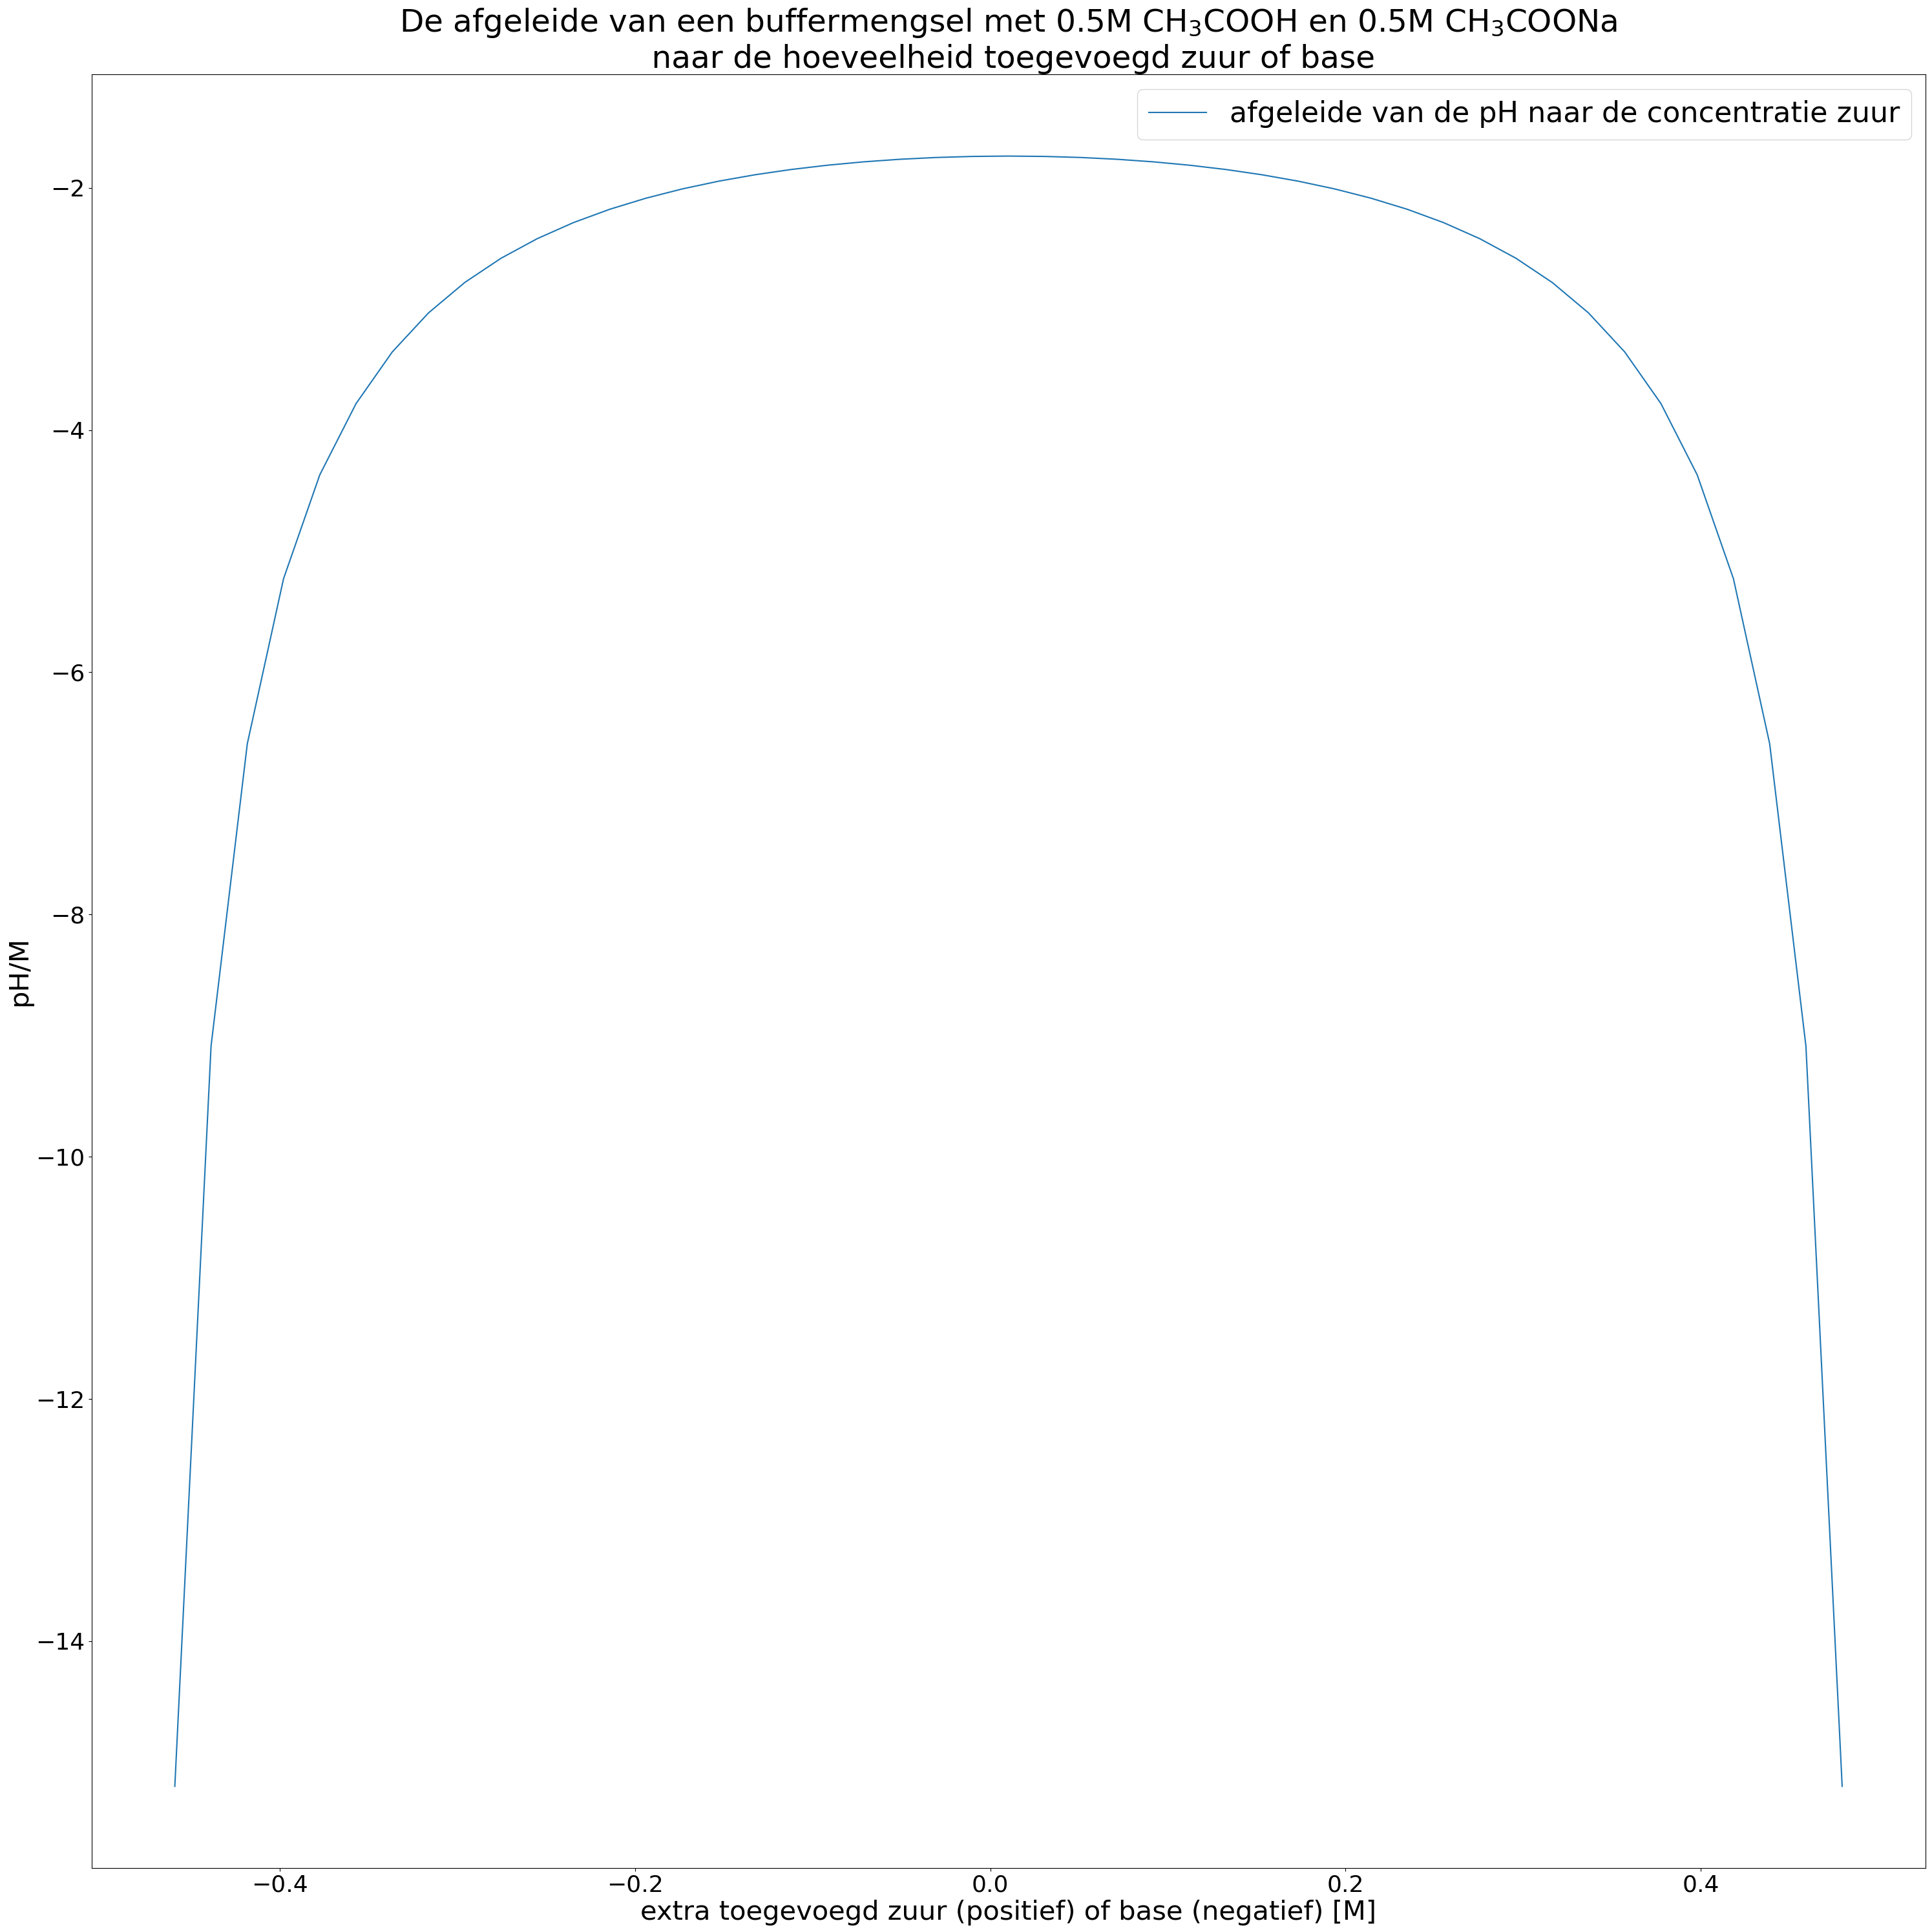

minimum van de afgeleide:
x =  0.0  dy/dx =  -1.7374191621223358


In [22]:
#voorbereidende oefening
cabegin = 0.5 #alles in molair doen
cbbegin = 0.5
pKa = 4.76
extrazuur = np.linspace(-0.5,0.5) #negatief toegevoegd zuur = toegevoegd base
fig, ax = plt.subplots(1,1, figsize = (30,30))
#ax.plot(extrazuur, pH_buffer(pKa, *nieuw_mengsel(cabegin, cbbegin, extrazuur, 0)), label = 'pH')
D1 = pH_buffer(pKa, *nieuw_mengsel(cabegin, cbbegin, extrazuur[:-1], 0))
D2 = pH_buffer(pKa, *nieuw_mengsel(cabegin, cbbegin, extrazuur[1:], 0))
afgeleide = (D2-D1)/(extrazuur[1]-extrazuur[0])
ax.plot(extrazuur[1:], afgeleide, label = 'afgeleide van de pH naar de concentratie zuur')
ax.set_xlabel('extra toegevoegd zuur (positief) of base (negatief) [M]', fontsize = 30)
ax.set_ylabel('pH/M', fontsize = 30)
ax.set_title('De afgeleide van een buffermengsel met 0.5M CH$_3$COOH en 0.5M CH$_3$COONa\n naar de hoeveelheid toegevoegd zuur of base', fontsize = 35)
ax.legend(fontsize = 32)
plt.yticks(fontsize = 26)
plt.xticks(fontsize = 26)
plt.tight_layout()
plt.savefig('pHafgeleidebuffer.png')
plt.show()
print('minimum van de afgeleide:')
print('x = ',(extrazuur[np.argmax(afgeleide)] + extrazuur[1+np.argmax(afgeleide)])/2, ' dy/dx = ', np.max(afgeleide))

#het is duidelijk minimaal rond 0

8318.433260268504
-0.00012021494537635104
8.5002500250025
Het equivalent volume is gelijk aan 0.009966240732481464 L


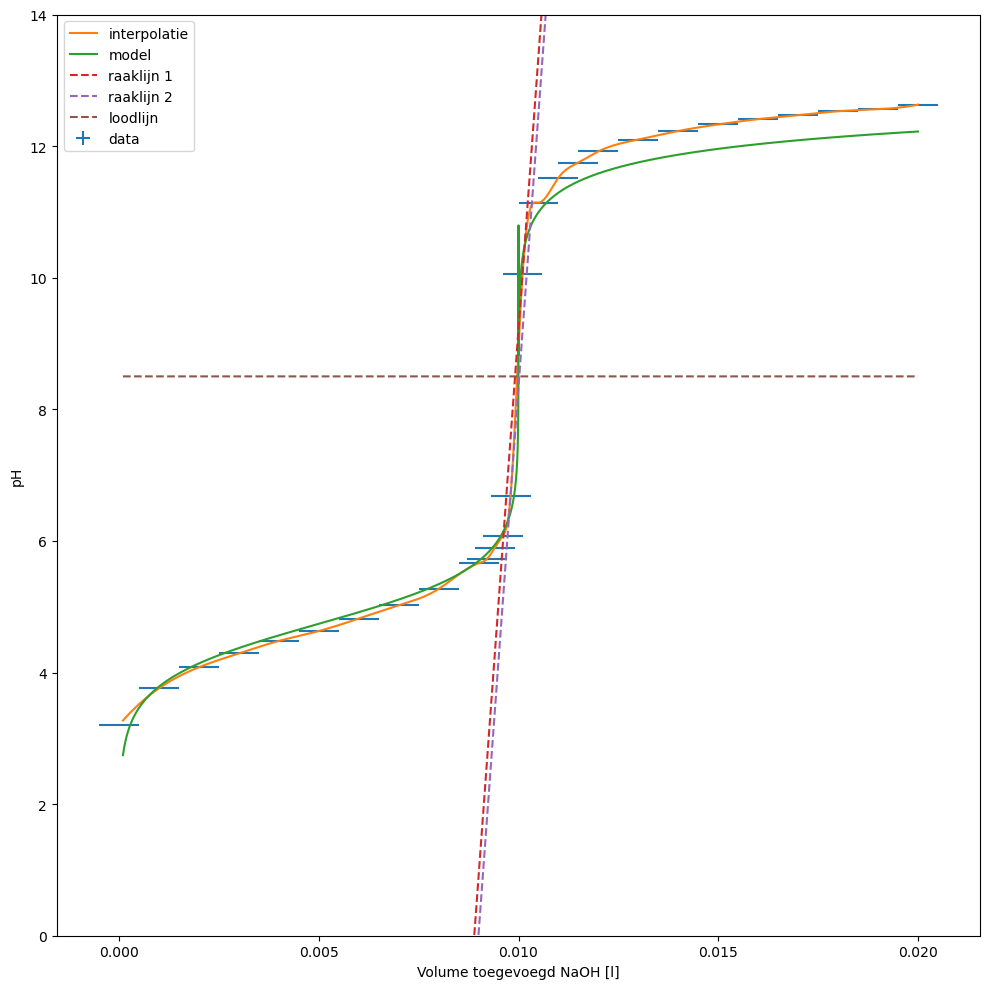

In [5]:
#de plot van de data en zo
adres = 'buffer/titratie2.txt'
volumes,pHs = np.loadtxt(adres, delimiter=",").T #volumes in ml
volumes *= 10**(-3) #vanaf nu volumes in l
volumelinspace = np.linspace(0.1e-3,20e-3,500000)
pHfunctie = CubicSpline(volumes, pHs)

#maak die rare constructie
#creeer de raaklijnen als lambdafuncties
afgeleide_pHfunctie = pHfunctie.derivative(nu = 1)
tweedeafgeleide_pHfunctie = pHfunctie.derivative(nu=2)
deriv2 = tweedeafgeleide_pHfunctie(volumelinspace)
minderiv2indx = np.argmin(deriv2)
maxderiv2indx = np.argmax(deriv2)
x1 = volumelinspace[minderiv2indx]
x2 = volumelinspace[maxderiv2indx]
rico1 = afgeleide_pHfunctie(x1)
rico2 = afgeleide_pHfunctie(x2)
rico = (rico1 + rico2)/2
y1 = pHfunctie(x1)
y2 = pHfunctie(x2)
raaklijn1 = lambda x: rico*(x-x1) + y1
raaklijn2 = lambda x: rico*(x-x2) + y2
print(rico)
#creeer die rare loodlijn daar
algemeneloodlijn = lambda x,b: -1/rico *x + b
print(-1/rico)
bwaardes = np.linspace(0,14,10000)
oppervlakteverschil = 1e6
for bval in bwaardes:
    snijpunt1 = (bval - y1 + rico*x1)/(rico + 1/rico) #snijpunt tussen raaklijn 1 en de loodlijn
    snijpunt2 = (bval - y2 + rico*x2)/(rico + 1/rico) #snijpunt tussen raaklijn 2 en de loodlijn
    verschil1 = lambda x: pHfunctie(x) - raaklijn1(x)
    verschil2 = lambda x: raaklijn2(x) - pHfunctie(x)
    xrange1 = np.linspace(x1, snijpunt1, 10000)
    xrange2 = np.linspace(snijpunt2, x2, 10000)
    oppervlakte1 = np.trapz(verschil1(xrange1), xrange1)
    oppervlakte2 = np.trapz(verschil2(xrange2), xrange2)
    delta = abs(oppervlakte1 - oppervlakte2)
    if delta < oppervlakteverschil:
        oppervlakteverschil = delta
        B = bval
print(B)
loodlijn = lambda x: algemeneloodlijn(x,B)
#zoek de intersectie tussen de loodlijn en de pHfunctie
afstand = 1e6
for volume in volumelinspace:
    delta = abs(loodlijn(volume) - pHfunctie(volume))
    if delta < afstand:
        afstand = delta
        equivalent_volume = volume

print('Het equivalent volume is gelijk aan', equivalent_volume, 'L')


fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(volumes, pHs, xerr = 0.5e-3, yerr = 0.01, linestyle = '', label = 'data')
ax.plot(volumelinspace, pHfunctie(volumelinspace), label = 'interpolatie')
ax.plot(volumelinspace, pH_experiment_approc(volumelinspace, [0.001, 4.74]), label = 'model', zorder = 2)
ax.plot(volumelinspace, raaklijn1(volumelinspace), linestyle = '--', label = 'raaklijn 1')
ax.plot(volumelinspace, raaklijn2(volumelinspace), linestyle = '--', label = 'raaklijn 2')
ax.plot(volumelinspace, loodlijn(volumelinspace), linestyle = '--', label = 'loodlijn')
ax.set_ylabel('pH')
ax.set_xlabel('Volume toegevoegd NaOH [l]')
ax.legend()
ax.set_ylim(0,14)
#ax.set_xlim(0.0075, 0.0125)
plt.tight_layout()
plt.show()

In [6]:
#bereken de molariteit in de maatkolf en zo
Veq, Vsamp, Vkolf, ckolf, M, mpercent, rho = sp.symbols('Veq Vsamp Vkolf ckolf M m% rho')
volume_maatkolf = classes.vergelijking(Veq*0.1/Vsamp, [Veq, Vsamp]) #Veq: equivalent volume, Vsamp: volume sample uit maatkolf
equivol = classes.datapunt(equivalent_volume, 1e-3, Veq)#neem aan: fout op equivalent volume is 1ml
sampvol = classes.datapunt(10e-3, 0.02e-3, Vsamp) #fout op samplevolume is 0.02ml, zie cursus maatglaswerk
rho_val = classes.datapunt(1.01, 0, rho)
molariteit_maatkolf = volume_maatkolf.evaluate([equivol, sampvol], None, ckolf)
print('concentratie in de maatkolf (in molair) is gelijk aan: ')
functies.latex_print_datapunt(molariteit_maatkolf)

#massapercent_winkelazijn = classes.vergelijking(ckolf*Vkolf/Vsamp * M  * 1/1000*100, [ckolf, Vkolf, Vsamp, M]) #de *1/1000 is om van g/L = g/kg naar g/g te gaan, de *100 maakt er een percentage van
massapercent_winkelazijn = classes.vergelijking(ckolf*M/rho, [ckolf, M, rho]) #massapercent is massa_ding/totale_massa, of molaire_rho/rho_tot (de eenheden kloppen)
kolfvolume = classes.datapunt(100e-3, 0.1e-3, Vkolf)
molairemassa = classes.datapunt(60.0, 0.1, M)
massapercent = massapercent_winkelazijn.evaluate([molariteit_maatkolf, molairemassa, rho_val], None, mpercent)
print('het massapercent azijn in de winkelazijn is gelijk aan: ')
functies.latex_print_datapunt(massapercent)


concentratie in de maatkolf (in molair) is gelijk aan: 
$ckolf = (10 \pm 1)\cdot 10^{-2}$
het massapercent azijn in de winkelazijn is gelijk aan: 
$m% = (59 \pm 5)\cdot 10^{-1}$


[0.001, 4.74]
[1.00e-03 4.74e+00 0.00e+00 1.00e-03 2.00e-03 3.00e-03 4.00e-03 5.00e-03
 6.00e-03 7.00e-03 8.00e-03 9.00e-03 9.20e-03 9.40e-03 9.60e-03 9.80e-03
 1.01e-02 1.05e-02 1.10e-02 1.15e-02 1.20e-02 1.30e-02 1.40e-02 1.50e-02
 1.60e-02 1.70e-02 1.80e-02 1.90e-02 2.00e-02]


C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return pKa - np.log10(ca/cb)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Ditctionary van minimize:
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 1.000e-03  4.740e+00 ...  1.900e-02  2.000e-02]
      nit: 0
      jac: [       nan        nan ...        nan        nan]
     nfev: 630
     njev: 21
 hess_inv: <29x29 LbfgsInvHessProduct with dtype=float64>
---------------------------
Minimale parameter waardes:
[1.00e-03 4.74e+00]
---------------------------
Minimale hybrid waardes:
[1.00e-03 4.74e+00 0.00e+00 1.00e-03 2.00e-03 3.00e-03 4.00e-03 5.00e-03
 6.00e-03 7.00e-03 8.00e-03 9.00e-03 9.20e-03 9.40e-03 9.60e-03 9.80e-03
 1.01e-02 1.05e-02 1.10e-02 1.15e-02 1.20e-02 1.30e-02 1.40e-02 1.50e-02
 1.60e-02 1.70e-02 1.80e-02 1.90e-02 2.00e-02]
---------------------------
------------------------
gok: 0.001
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002903C62E200>
Root scalar worked!
------------------------
gok: 4.74
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002903C5E1260>
Root sc

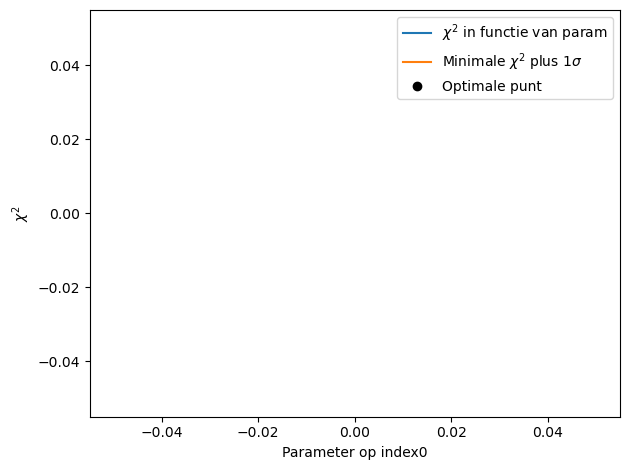

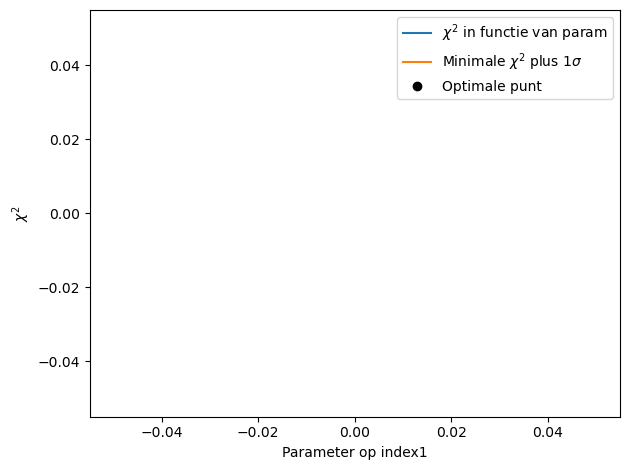

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: nan
De gereduceerde chi^2 waarde is: nan


c:\Users\User\Documents\Cas\Unif\2e can\experimentele\github\Experimentele_vscode\General\functies.py:734: RuntimeWarning: divide by zero encountered in scalar divide
  if fout[0]/fout[1] < 1.25 and fout[0]/fout[1] > 0.8:
C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: invalid value encountered in log10
  return pKa - np.log10(ca/cb)


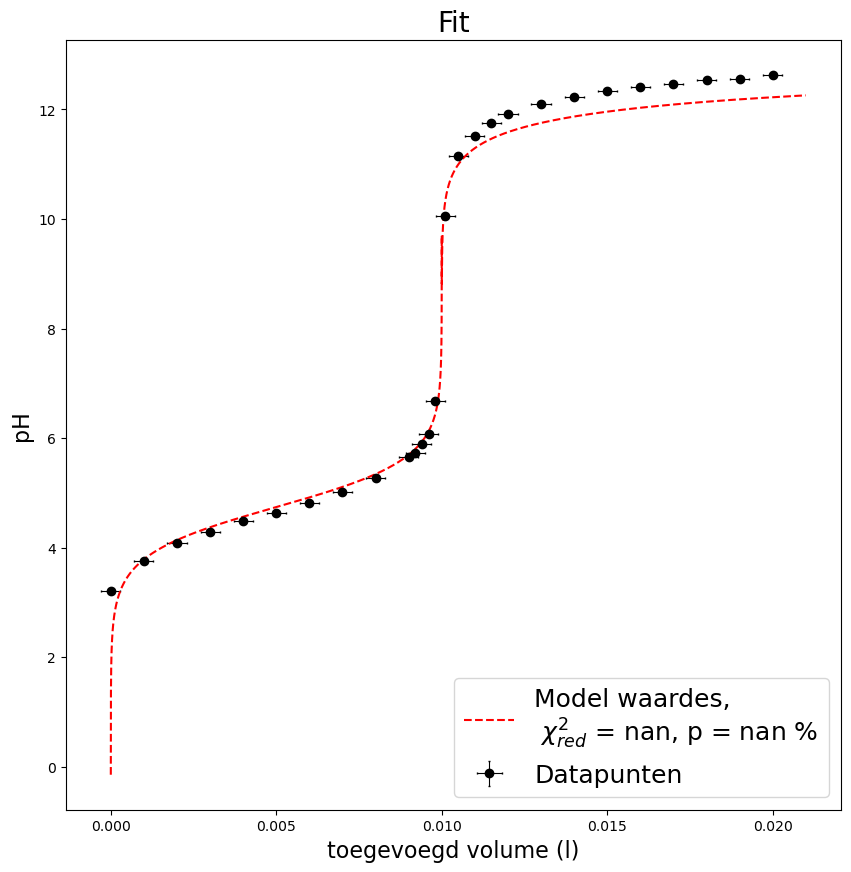

[[0.001, (9.999999999999994e-05, 0.0), 'S'],
 [4.74, (0.4740000000000002, 0.0), 'S']]

In [7]:
#fit overal:
def invals(x,y):
    return [0.001,4.74]
functies.fit_2D(['n0', 'pKa'], pH_experiment_approc, invals, volumes, pHs, np.full(np.shape(volumes),1e-3)**2/12, np.full(np.shape(pHs),0.01)**2/12,  x_as_titel= 'toegevoegd volume (l)', y_as_titel = 'pH', bounds=[(1e-7,1), (4,7)], detailed_logs=True)

In [8]:
#test het met 1D fit:
outp = functies.fit(['n0', 'pKa'], pH_experiment_approc, invals, volumes, pHs, np.full(np.shape(pHs),0.01))#,  x_as_titel= 'toegevoegd volume (l)', y_as_titel = 'pH', bounds=[(0,5), (4,7)], detailed_logs=False)

[[0.0005, 0.0015], [2.37, 7.11]]
n0 heeft als waarde: 0.001 + 0.0005 - 0.0005 met 68% betrouwbaarheidsinterval: [0.0005, 0.0015] 
pKa heeft als waarde: 4.74 + 2.37 - 2.37 met 68% betrouwbaarheidsinterval: [2.37, 7.11] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: inf


C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return pKa - np.log10(ca/cb)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
c:\Users\User\Documents\Cas\Unif\2e can\experimentele\github\Experimentele_vscode\General\functies.py:294: RuntimeWarning: invalid value encountered in scalar subtract
  outp = np.append(outp, chi2_bereken(kopie, x_val, y_val, y_err, soort_fout, model, aditional_params=aditional_params) - chi2.ppf(0.68, df=aant_param) - chi_min)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: invalid value encountered in log10
  return pKa - np.log10(ca/cb)


[0.001, 4.69]
[1.00e-03 4.69e+00 1.00e-03 2.00e-03 3.00e-03 4.00e-03 5.00e-03 6.00e-03
 7.00e-03 8.00e-03 9.00e-03 9.20e-03]
Ditctionary van minimize:
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 1.000e-03  4.690e+00  1.000e-03  2.000e-03  3.000e-03
             4.000e-03  5.000e-03  6.000e-03  7.000e-03  8.000e-03
             9.000e-03  9.200e-03]
      nit: 0
      jac: [-8.159e+07  5.537e+04 -2.807e+06  5.173e+05  1.589e+06
             1.473e+06  2.502e+06  2.002e+06  1.885e+06  1.437e+06
            -1.825e+06  4.348e+06]
     nfev: 182
     njev: 14
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
---------------------------
Minimale parameter waardes:
[1.00e-03 4.69e+00]
---------------------------
Minimale hybrid waardes:
[1.00e-03 4.69e+00 1.00e-03 2.00e-03 3.00e-03 4.00e-03 5.00e-03 6.00e-03
 7.00e-03 8.00e-03 9.00e-03 9.20e-03]
---------------------------
------------------------
gok: 0.001
<function find_sigma

C:\Users\User\AppData\Local\Temp\ipykernel_9220\1307860434.py:2: RuntimeWarning: divide by zero encountered in log10
  return pKa - np.log10(ca/cb)


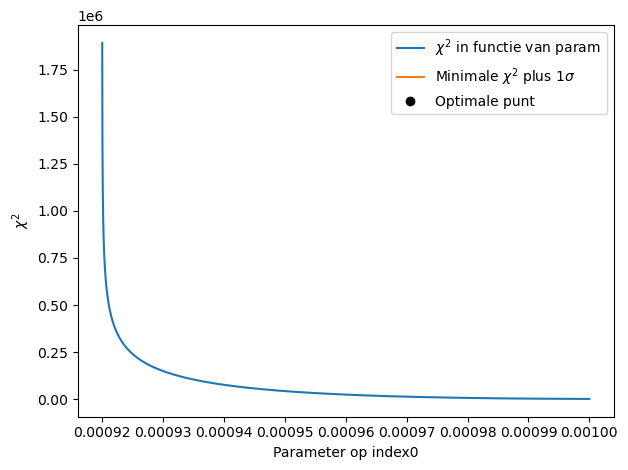

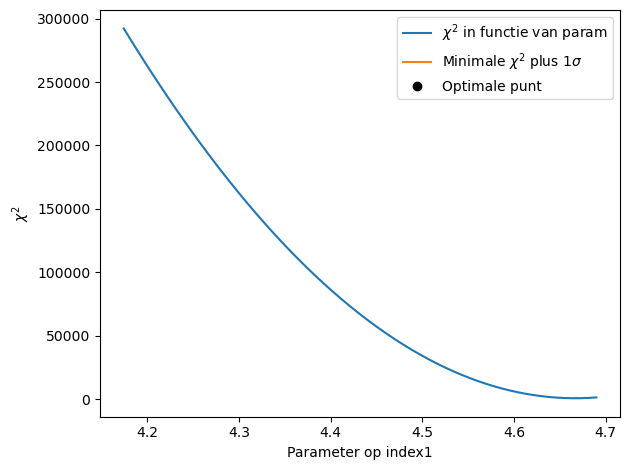

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: nan
De gereduceerde chi^2 waarde is: nan


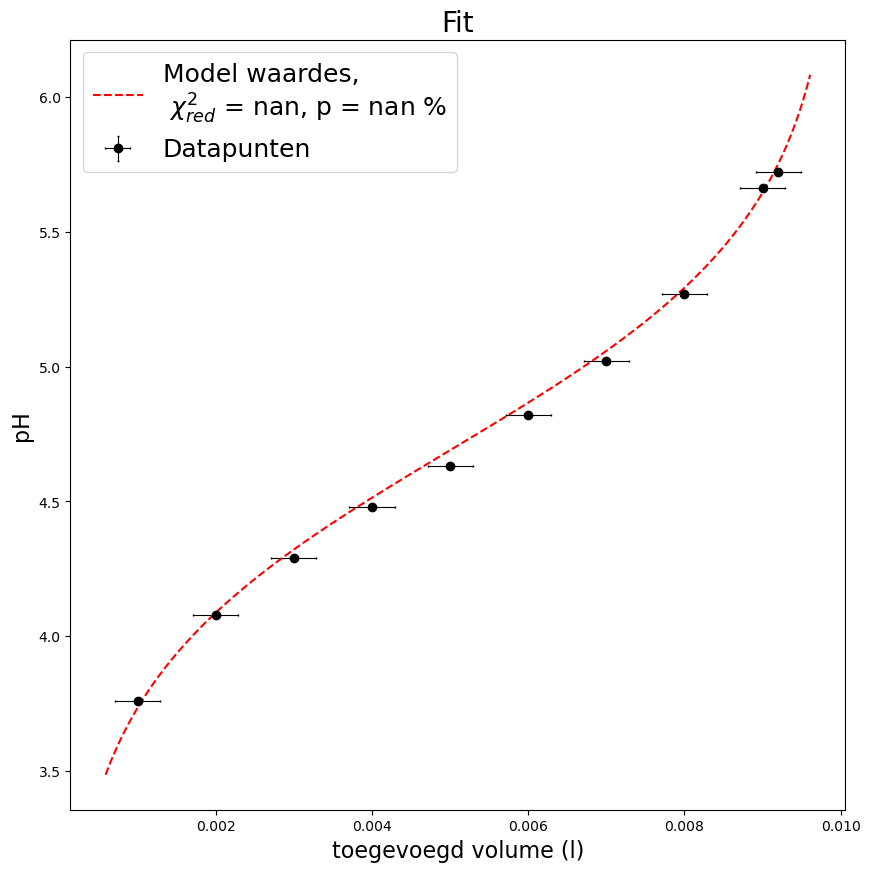

[[0.001, (9.999999999999994e-05, 0.0), 'S'],
 [4.69, (0.4690000000000003, 0.0), 'S']]

In [9]:
#fit het buffergebied binnen pKa - 1 tot pKa + 1
indxmin = 0
while pHs[indxmin] < 3.74:
    indxmin+=1
indxmax = indxmin+1
while pHs[indxmax] < 5.74:
    indxmax += 1
volumesreduced = volumes[indxmin: indxmax]
pHsreduced = pHs[indxmin: indxmax]
def invals(x,y):
    return [0.001, 4.69]
functies.fit_2D(['n_0', 'pKa'], pH_experiment_bufferzone, invals, volumesreduced, pHsreduced, np.full(np.shape(volumesreduced),1e-3)**2/12, np.full(np.shape(pHsreduced),0.01)**2/12,
                 detailed_logs=True, x_as_titel= 'toegevoegd volume (l)', y_as_titel = 'pH', bounds=[(0.00094,5), (0,14)])